<a href="https://www.kaggle.com/code/ghareeba/01-baseline-model-training-and-evaluation?scriptVersionId=244958953" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### 📑 Table of Contents
- [Introduction](#Introduction)
- [Setup and Imports](#Setup-and-Imports)
- [Data Preprocessing and Loading](#Data-Preprocessing-and-Loading)
- [Model Architecture](#Model-Architecture)
- [Training](#Training)
- [Evaluation](#Model-Evaluation)

# Introduction

This notebook demonstrates how to build and train a deep learning model from scratch for the task of binary image classification using the Cats vs. Dogs dataset. The primary goal is to develop a convolutional neural network (CNN) that can accurately distinguish between images of cats and dogs.

Image classification is a foundational problem in computer vision with wide-ranging applications from autonomous driving to medical diagnostics. The Cats vs. Dogs dataset offers a perfect balance between simplicity and complexity: while the task of differentiating cats from dogs is intuitive, the dataset’s size and variability demand a sufficiently large and capable model. This makes it an ideal benchmark for developing, optimizing, and evaluating deep learning architectures.

This notebook is the first in a planned series of notebooks that together cover the full lifecycle of building efficient deep learning models. Future notebooks will explore:
- **Model pruning** to reduce model size and computational requirements without significant loss in accuracy.  
- **Knowledge distillation** to transfer learned knowledge from this larger “teacher” model to a smaller, more efficient “student” model.  
- **Quantization** to optimize the model for deployment on resource-constrained devices.  
- **Deployment** strategies for practical use cases.

The CNN architecture implemented here is designed to be both interpretable and sufficiently complex, serving as an ideal foundation for the optimization techniques discussed in the subsequent notebooks.

---


The Cats vs. Dogs dataset consists of three subsets:

- **Training set:** 20,000 images (10,000 cats and 10,000 dogs) with diverse poses, backgrounds, and lighting conditions.  
- **Validation set:** 5,000 images (2,500 cats and 2,500 dogs) used for hyperparameter tuning and intermediate evaluation.  
- **Test set:** 12,461 images (6,242 cats and 6,219 dogs) reserved for final evaluation on unseen data.

All images will be preprocessed by resizing and normalization to ensure consistency and stable training.

# Setup and Imports

In this section, we import the necessary libraries and configure the runtime environment. This includes setting random seeds for reproducibility and selecting the appropriate device (CPU or GPU) for model training.

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import tqdm
import pickle
from collections import OrderedDict
from sklearn.metrics import  (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, roc_curve, confusion_matrix
)
from torchinfo import summary

# pytorch essientials
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Enviornment configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Preprocessing and Loading

In this section, we prepare the dataset for training. This includes:

- Defining image transformations such as resizing, normalization, and data augmentation
- Loading the dataset using `ImageFolder`
- Creating DataLoaders for training, validation, and test sets

---

In [2]:
train_folder = "/kaggle/input/dogs-vs-cats/dataset/train"
val_folder = "/kaggle/input/dogs-vs-cats/dataset/validation"
test_folder = "/kaggle/input/dogs-vs-cats/dataset/test"

## Compute Dataset Mean and Standard Deviation

To normalize the dataset properly, we compute the channel-wise mean and standard deviation of the training set. This ensures the input distribution is centered and scaled, which stabilizes and speeds up training.

---

In [3]:
image_size = 128
batch_size = 128

In [4]:
temp_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

temp_dataset = datasets.ImageFolder(root=train_folder, transform=temp_transforms)
print(f"Classes: {temp_dataset.find_classes(train_folder)[1]}")
temp_dataloader = DataLoader(dataset=temp_dataset, batch_size=batch_size)
print(type(temp_dataloader))

Classes: {'cats': 0, 'dogs': 1}
<class 'torch.utils.data.dataloader.DataLoader'>


In [5]:
def compute_mean_std(loader, cache_file="mean_std.pkl"):
    if os.path.exists(cache_file):
        try:
            with open(cache_file, 'rb') as f:
                stats = pickle.load(f)
                if "mean" in stats and "std" in stats:
                    print("Loaded mean and std from cache.")
                    return stats["mean"], stats["std"]
        except Exception as e:
            print(f"Failed to load cache file: {e}")
            print("Recomputing mean and std...")

    n_images = 0
    mean = 0.
    std = 0.

    for images, _ in tqdm.tqdm(loader, desc="Computing mean and std"):
        batch_sample = images.size(0)
        images = images.view(batch_sample, images.size(1), -1)  # (B, C, H*W)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_images += batch_sample

    mean /= n_images
    std /= n_images

    with open(cache_file, 'wb') as f:
        pickle.dump({"mean": mean, "std": std}, f)
        print(f"Saved mean and std to cache file: {cache_file}")

    return mean, std


In [6]:
mean, std = compute_mean_std(temp_dataloader)
print(f"mean: {mean.tolist()}, std: {std.tolist()}")

Computing mean and std: 100%|██████████| 157/157 [01:31<00:00,  1.72it/s]

Saved mean and std to cache file: mean_std.pkl
mean: [0.48825347423553467, 0.45504486560821533, 0.4168395400047302], std: [0.2225690633058548, 0.21782387793064117, 0.218031108379364]


# Preprocessing and Loading

In this section, we prepare the dataset for training. This includes:

- Defining image transformations such as resizing, normalization, and data augmentation
- Loading the dataset using `ImageFolder`
- Creating DataLoaders for training, validation, and test sets

---

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

transform_val = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

In [8]:
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_folder, transform=transform_val)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform_val)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [9]:
class_names = train_dataset.classes
print(class_names)

['cats', 'dogs']


## Visualize Sample Images

Before training, it's helpful to visualize some samples from the training set to verify image shapes, class balance, and augmentation effects.

---

In [10]:
def imshow(inp, ax, title=None):
    # Unnormalize
    if isinstance(mean, torch.Tensor):
        mean_tensor = mean.view(3, 1, 1)
        std_tensor = std.view(3, 1, 1)
    else:
        mean_tensor = torch.tensor(mean).view(3, 1, 1)
        std_tensor = torch.tensor(std).view(3, 1, 1)

    inp = inp.cpu() * std_tensor + mean_tensor  # unnormalize
    inp = inp.numpy().transpose((1, 2, 0))  # C x H x W → H x W x C
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

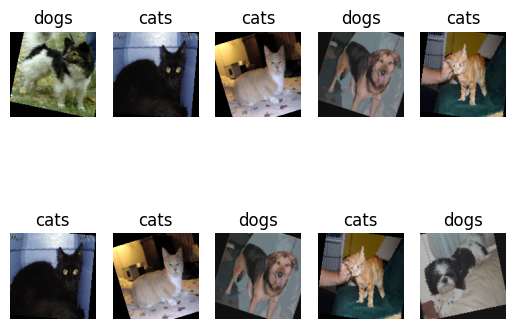

In [11]:
image = iter(train_dataloader)
image, label = next(image)
fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        imshow(image[i+j], axs[i, j],class_names[label[i+j]])

# Model Architecture

In this section, we define a custom Convolutional Neural Network (CNN) from scratch to solve the binary image classification task of distinguishing between cats and dogs.

This model is intentionally designed with enough depth and parameter complexity to make it a suitable candidate for future optimization techniques such as:
- **Pruning**
- **Knowledge Distillation**
- **Quantization**

These techniques will be explored in later notebooks as part of this project series.

---

### Why This Architecture?

The goal is to strike a balance between:
- **Simplicity** — so that the architecture is understandable and easy to analyze.
- **Complexity** — enough parameters and layers to allow for non-trivial learning and optimizations.

This CNN architecture contains:
- Multiple **convolutional layers** to extract features
- **Batch normalization** to stabilize and speed up training
- **ReLU activations** to introduce non-linearity
- **Max pooling layers** to reduce spatial dimensions
- **Dropout** for regularization
- **Fully connected layers** that map extracted features to a final binary classification output using a **sigmoid activation**

---

In [12]:
conv1_layer = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout2d(0.2),
)

conv2_layer = nn.Sequential(
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout2d(0.2),
)

conv3_layer = nn.Sequential(
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.MaxPool2d(kernel_size=3),
)

conv4_layer = nn.Sequential(
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.MaxPool2d(kernel_size=3)
)

fully_connected = nn.Sequential(
    nn.Flatten(),
    nn.Linear(14*14*128, 1024),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.BatchNorm1d(32),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

model = nn.Sequential(OrderedDict(
    [
        ('conv1_layer', conv1_layer),
        ('conv2_layer', conv2_layer),
        ('conv3_layer', conv3_layer),
        ('conv4_layer', conv4_layer),
        ('fully_connected', fully_connected)
    ])
)

### Model Summary

We use `torchinfo` to generate a detailed summary of the model. This provides:

- Total number of layers and parameters
- Trainable vs. non-trainable parameters
- Input and output sizes at each layer

This is particularly helpful when analyzing the effect of pruning, quantization, and distillation in later stages of this project.


In [13]:
summary(model, input_size=(1, 3, image_size, image_size), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Sequential                               [1, 3, 128, 128]          [1, 1]                    --                        True
├─Sequential: 1-1                        [1, 3, 128, 128]          [1, 16, 128, 128]         --                        True
│    └─Conv2d: 2-1                       [1, 3, 128, 128]          [1, 16, 128, 128]         448                       True
│    └─BatchNorm2d: 2-2                  [1, 16, 128, 128]         [1, 16, 128, 128]         32                        True
│    └─ReLU: 2-3                         [1, 16, 128, 128]         [1, 16, 128, 128]         --                        --
│    └─Dropout2d: 2-4                    [1, 16, 128, 128]         [1, 16, 128, 128]         --                        --
├─Sequential: 1-2                        [1, 16, 128, 128]         [1, 32, 128, 128]         --                        True
│    └─

# Training

In this section, we define and execute the training loop for our custom convolutional neural network (CNN). The objective is to enable the model to accurately classify images from the `Cats vs. Dogs` dataset.

### Key Components of the Training Loop:

- **Model Architecture:** A deep CNN with four convolutional layers followed by a multi-layer fully connected classifier.
- **Loss Function:** `BCELoss` (Binary Cross-Entropy Loss), ideal for binary classification problems like ours.
- **Optimizer:** `AdamW` is used for its adaptive learning rate and effective weight decay, which helps improve generalization.
- **Learning Rate Scheduler:**  
  A **Cosine Annealing Scheduler** is integrated to adjust the learning rate over epochs. This scheduling strategy reduces the learning rate gradually following a cosine curve, helping the model converge more smoothly and potentially escape local minima in the loss landscape.

  > Cosine annealing can be particularly beneficial when training deep models, especially for tasks where long-term fine-tuning is required.

- **Validation:**  
  At the end of each epoch, the model is evaluated on a separate validation set to:
  - Track performance (loss, accuracy, and custom metrics)
  - Prevent overfitting through early stopping

- **Checkpointing (Optional):**  
  The best model (based on validation loss) is saved during training, enabling recovery and future evaluation.

- **Early Stopping (Optional):**  
  If the validation loss does not improve after a defined number of epochs (`patience`), training is halted early to avoid overfitting.

### What's Next?

This training phase sets the foundation for **model compression and optimization**. The trained model will later serve as a **teacher** in the knowledge distillation process and as a target for **pruning** and **quantization** strategies.

---


In [14]:
def train_network(
    model,
    loss_func,
    train_loader,
    val_loader=None,
    score_funcs=None,
    epochs=50,
    checkpoint_file=None,
    optimizer=None,
    lr_scheduler=None,
    patience=10,
    device="cpu"
):


    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters())

    model.to(device)
    print(f"Model operating on: {device}")

    best_val_loss = float("inf")
    num_bad_epochs = 0
    if score_funcs is not None:
        metrics = {name:[] for name in score_funcs}
    metrics["train_loss"] = []
    metrics["val_loss"] = []
    

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm.tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] - Training")

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        metrics["train_loss"].append(avg_train_loss)
        print(f"Epoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                preds_list = []
                labels_list = []
                for val_inputs, val_labels in val_loader:
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device).float()
                    outputs = model(val_inputs).squeeze(1)
                    loss = loss_func(outputs, val_labels)
                    val_loss += loss.item()

                    preds = (outputs > 0.5).float()
                    correct += (preds == val_labels).sum().item()
                    total += val_labels.size(0)

                    preds_list.append(preds.cpu())
                    labels_list.append(val_labels.cpu())

            avg_val_loss = val_loss / len(val_loader)
            metrics["val_loss"].append(avg_val_loss)
            print(f"→ Validation Loss: {avg_val_loss:.4f}")

            # Score functions (optional)
            if score_funcs:
                preds_all = torch.cat(preds_list)
                labels_all = torch.cat(labels_list)
                for name, func in score_funcs.items():
                    metric = func(preds_all, labels_all)
                    metrics[name].append(metric)
                    print(f"→ {name}: {metric:.4f}")
                del preds_all
                del labels_all

            # Early stopping and checkpointing
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                num_bad_epochs = 0
                if checkpoint_file:
                    checkpoint = {'model': model,
                                  'state_dict': model.state_dict(),
                                  'optimizer' : optimizer.state_dict()}

                    torch.save(checkpoint, 'checkpoint.pth')
                    print("Model checkpoint saved.")
            else:
                num_bad_epochs += 1
                print(f"Validation loss did not improve for {num_bad_epochs} epoch(s).")

            if num_bad_epochs >= patience:
                print("Early stopping triggered.")
                break

        # Step LR scheduler
        if lr_scheduler is not None:
            lr_scheduler.step()

    print("Training complete.")
    return metrics


In [ ]:
epochs = 200
loss_func = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//15, eta_min=0.0001)
checkpoint_file = "dummy"


results = train_network(model=model,
                        loss_func=loss_func,
                        train_loader=train_dataloader, 
                        val_loader=val_dataloader,
                        score_funcs = {
                        "accuracy": accuracy_score,
                        "f1_score": f1_score
                        },
                        checkpoint_file= checkpoint_file, 
                        optimizer=optimizer, 
                        lr_scheduler=scheduler, 
                        epochs=epochs, 
                        device = device)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Model Evaluation

This section evaluates the trained model's performance on unseen data using the validation and test sets. 
The goal is to assess how well the model generalizes beyond the training set.

We perform the following:

- Compute predicted probabilities and class predictions
- Display a confusion matrix to visualize classification performance
- Calculate key classification metrics: accuracy, precision, recall, F1 score, and ROC-AUC
- Visualize the ROC curve for probabilistic performance evaluation

These metrics and visualizations are essential for understanding model behavior, especially in real-world applications where false positives and false negatives may have different costs.


In [15]:
checkpoint = torch.load("/kaggle/input/cats-vs-dogs/pytorch/default/1/checkpoint.pth", weights_only=False)
model = checkpoint["model"]
model.load_state_dict(checkpoint['state_dict'])
summary(model, input_size=(1, 3, image_size, image_size), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Sequential                               [1, 3, 128, 128]          [1, 1]                    --                        True
├─Sequential: 1-1                        [1, 3, 128, 128]          [1, 16, 128, 128]         --                        True
│    └─Conv2d: 2-1                       [1, 3, 128, 128]          [1, 16, 128, 128]         448                       True
│    └─BatchNorm2d: 2-2                  [1, 16, 128, 128]         [1, 16, 128, 128]         32                        True
│    └─ReLU: 2-3                         [1, 16, 128, 128]         [1, 16, 128, 128]         --                        --
│    └─Dropout2d: 2-4                    [1, 16, 128, 128]         [1, 16, 128, 128]         --                        --
├─Sequential: 1-2                        [1, 16, 128, 128]         [1, 32, 128, 128]         --                        True
│    └─

In [16]:
def test_network(model, test_loader, score_funcs=None, device="cpu"):
    model.to(device)
    model.eval()
    pred_prob = []
    ground_truth = []
    with torch.no_grad():
        for test_inputs, test_labels in tqdm.tqdm(test_loader,desc=f"Evaluating"):
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device).float()
            outputs = model(test_inputs).squeeze(1)
            pred_prob.append(outputs.cpu())
            ground_truth.append(test_labels.cpu())

    pred_prob = torch.cat(pred_prob)
    ground_truth = torch.cat(ground_truth)
    return pred_prob, ground_truth

In [17]:
probs, labels = test_network(model, val_dataloader, device=device)
preds = (probs >= 0.5).int().cpu().numpy()
labels = labels.int().cpu().numpy()
np.set_printoptions(suppress=True)

Evaluating: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


In [18]:
print(f"model's accuracy score on validation set at 50% cuttoff: {accuracy_score((probs>=0.5), labels)*100}%")

model's accuracy score on validation set at 50% cuttoff: 94.06%


In [19]:
probs, labels = test_network(model, test_dataloader, device=device)
preds = (probs >= 0.5).int().cpu().numpy()
labels = labels.int().cpu().numpy()
np.set_printoptions(suppress=True)
print(f"model's accuracy score on test set at 50% cuttoff: {accuracy_score((probs>=0.5), labels)*100:0.2f}%")

Evaluating: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]

model's accuracy score on test set at 50% cuttoff: 94.30%


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6242
           1       0.95      0.93      0.94      6219

    accuracy                           0.94     12461
   macro avg       0.94      0.94      0.94     12461
weighted avg       0.94      0.94      0.94     12461

Precision: 0.9527
Recall: 0.9326
F1 Score: 0.9426
ROC AUC Score: 0.9887


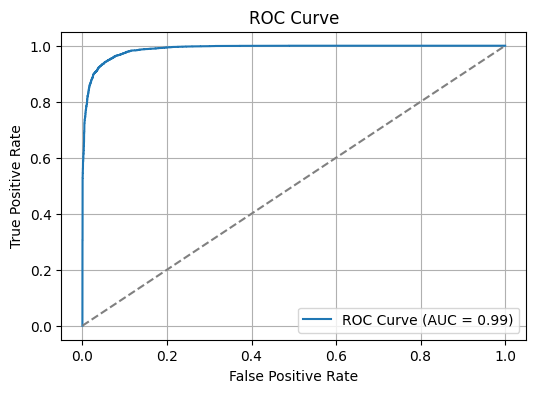

In [20]:
# Additional metrics
print("Classification Report:")
print(classification_report(labels, preds))

print(f"Precision: {precision_score(labels, preds):.4f}")
print(f"Recall: {recall_score(labels, preds):.4f}")
print(f"F1 Score: {f1_score(labels, preds):.4f}")
print(f"ROC AUC Score: {roc_auc_score(labels, probs):.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(labels, probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(labels, probs):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

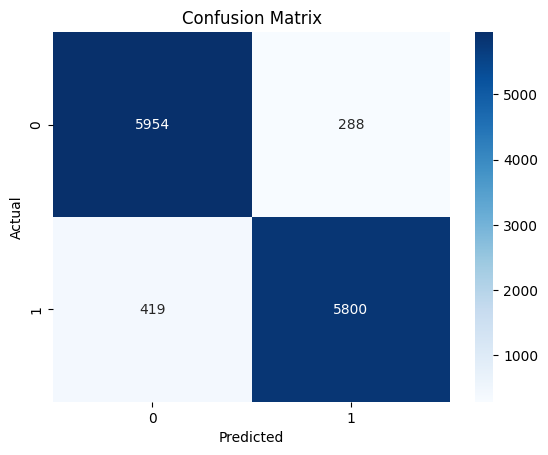

In [21]:
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## ✅ Conclusion

In this notebook, we developed a binary image classification model using PyTorch. We walked through data preprocessing, model design, training, evaluation, and metric visualization.

This notebook is the **first** in a multi-part series that explores model compression techniques. The trained model here serves as a **baseline** for evaluating methods such as:
- **Pruning**
- **Quantization**
- **Knowledge Distillation**

In the upcoming notebooks, we will build on this model to reduce its size and improve inference speed — making it deployable on resource-constrained environments without sacrificing much performance.
